In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,roc_auc_score, roc_curve
from sklearn.tree import plot_tree, export_text
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter

In [164]:
file_path1 = r"content/bank-additional-full.csv"
file_path2 = r"content/bank-additional.csv"
df_full = pd.read_csv(file_path1,sep=";")
df_small = pd.read_csv(file_path2,sep=";")

# Check if both datasets have the same structure
if df_full.columns.equals(df_small.columns):
    print("Both datasets have the same structure. Then merge")
    df = pd.concat([df_full, df_small], ignore_index=True)
else:
    print("Datasets have different structures. ")
    df = df_full


Both datasets have the same structure. Then merge


In [165]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45302,30,admin.,married,basic.6y,no,yes,yes,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,no
45303,39,admin.,married,high.school,no,yes,no,telephone,jul,fri,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.959,5228.1,no
45304,27,student,single,high.school,no,no,no,cellular,may,mon,...,2,999,1,failure,-1.8,92.893,-46.2,1.354,5099.1,no
45305,58,admin.,married,high.school,no,no,no,cellular,aug,fri,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no


In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45307 entries, 0 to 45306
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             45307 non-null  int64  
 1   job             45307 non-null  object 
 2   marital         45307 non-null  object 
 3   education       45307 non-null  object 
 4   default         45307 non-null  object 
 5   housing         45307 non-null  object 
 6   loan            45307 non-null  object 
 7   contact         45307 non-null  object 
 8   month           45307 non-null  object 
 9   day_of_week     45307 non-null  object 
 10  duration        45307 non-null  int64  
 11  campaign        45307 non-null  int64  
 12  pdays           45307 non-null  int64  
 13  previous        45307 non-null  int64  
 14  poutcome        45307 non-null  object 
 15  emp.var.rate    45307 non-null  float64
 16  cons.price.idx  45307 non-null  float64
 17  cons.conf.idx   45307 non-null 

Handling Missing Values

In [167]:
df.dropna(subset=['y'], inplace=True)#droping empty values on target column
df.replace('unknown', np.nan, inplace=True)
for col in df.select_dtypes(include=['object']).columns:
    df.replace('unknown', np.nan, inplace=True)
    df.dropna(inplace=True)
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col].fillna(df[col].mean(), inplace=True)

C:\Users\tharu\AppData\Local\Temp\ipykernel_13636\2305517639.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


Training, Validation and Test Sets

In [168]:
train_df, remain_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df["y"])

val_df, test_df = train_test_split(remain_df, test_size=0.5, random_state=42, stratify=remain_df["y"])

print('train_df.shape :',train_df.shape)
print('val_df.shape :',val_df.shape)
print('test_df.shape :',test_df.shape)

train_df.shape : (20146, 21)
val_df.shape : (6716, 21)
test_df.shape : (6716, 21)


Identify the input and target columns

In [169]:
input_cols =  df.drop('y', axis=1).columns.tolist()
target_col = 'y'
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [172]:
print(numeric_cols)

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [173]:
print(categorical_cols)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


Scaling Numeric Features

In [174]:
scaler = MinMaxScaler().fit(df[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])


Encoding Categorical Data

In [175]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(train_inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])
# Drop original categorical columns
train_inputs = train_inputs.drop(columns=categorical_cols)
val_inputs = val_inputs.drop(columns=categorical_cols)
test_inputs = test_inputs.drop(columns=categorical_cols)

In [179]:
# Combine numeric and encoded features
X_train = train_inputs
y_train = train_targets.replace({'yes': 1, 'no': 0})  # Binary encoding for SMOTE
X_val = val_inputs
y_val = val_targets.replace({'yes': 1, 'no': 0})
X_test = test_inputs
y_test = test_targets.replace({'yes': 1, 'no': 0})

C:\Users\tharu\AppData\Local\Temp\ipykernel_13636\778713148.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = train_targets.replace({'yes': 1, 'no': 0})  # Binary encoding for SMOTE
C:\Users\tharu\AppData\Local\Temp\ipykernel_13636\778713148.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val = val_targets.replace({'yes': 1, 'no': 0})
C:\Users\tharu\AppData\Local\Temp\ipykernel_13636\778713148.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain t

In [180]:
# Check class distribution before SMOTE
print("Class distribution before SMOTE:", Counter(y_train))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:", Counter(y_train_resampled))

Class distribution before SMOTE: Counter({0: 17609, 1: 2537})
Class distribution after SMOTE: Counter({0: 17609, 1: 17609})


In [181]:
input_size = X_train_resampled.shape[1]
print("Input size:", input_size)


Input size: 57


Training Random Forest

In [182]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(n_jobs=-1, random_state=42)

Evaluation

In [183]:
train_preds = model.predict(X_train_resampled)
train_preds
accuracy_score( y_train_resampled,train_preds)
val_preds = model.predict(X_val)
accuracy_score(y_val , val_preds)
print(classification_report(y_val , val_preds))

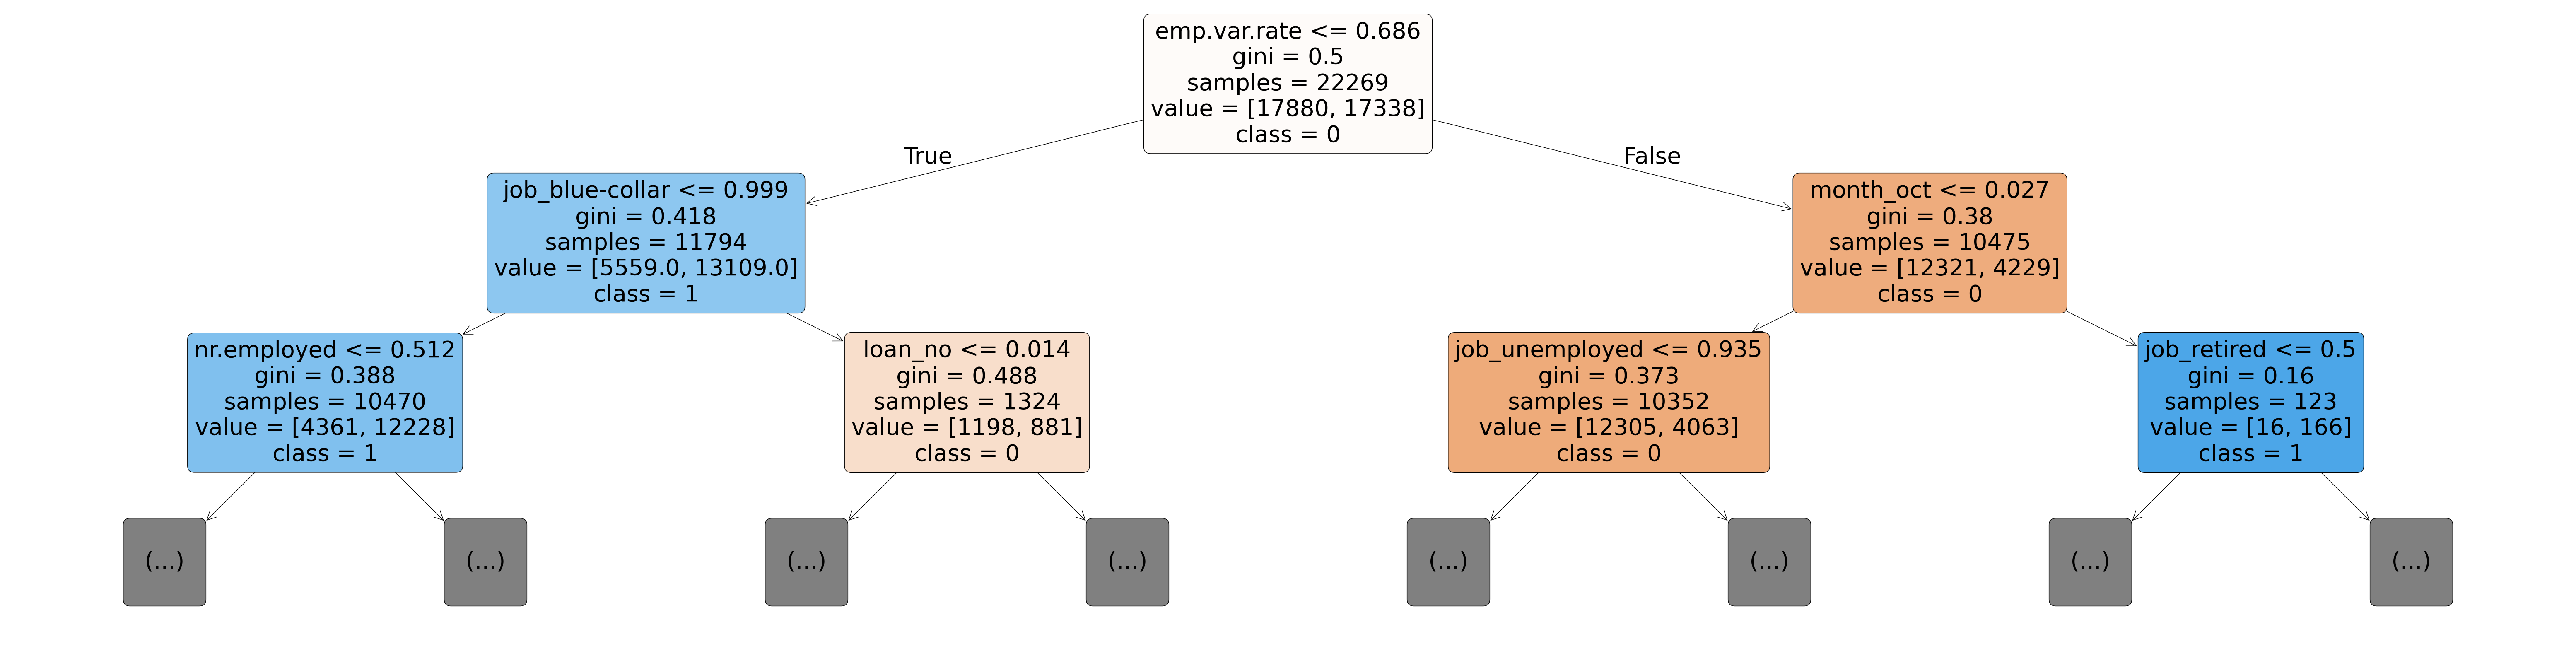

In [189]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[0], max_depth=2, feature_names=X_train_resampled.columns, filled=True, rounded=True, class_names=[str(cls) for cls in model.classes_] );

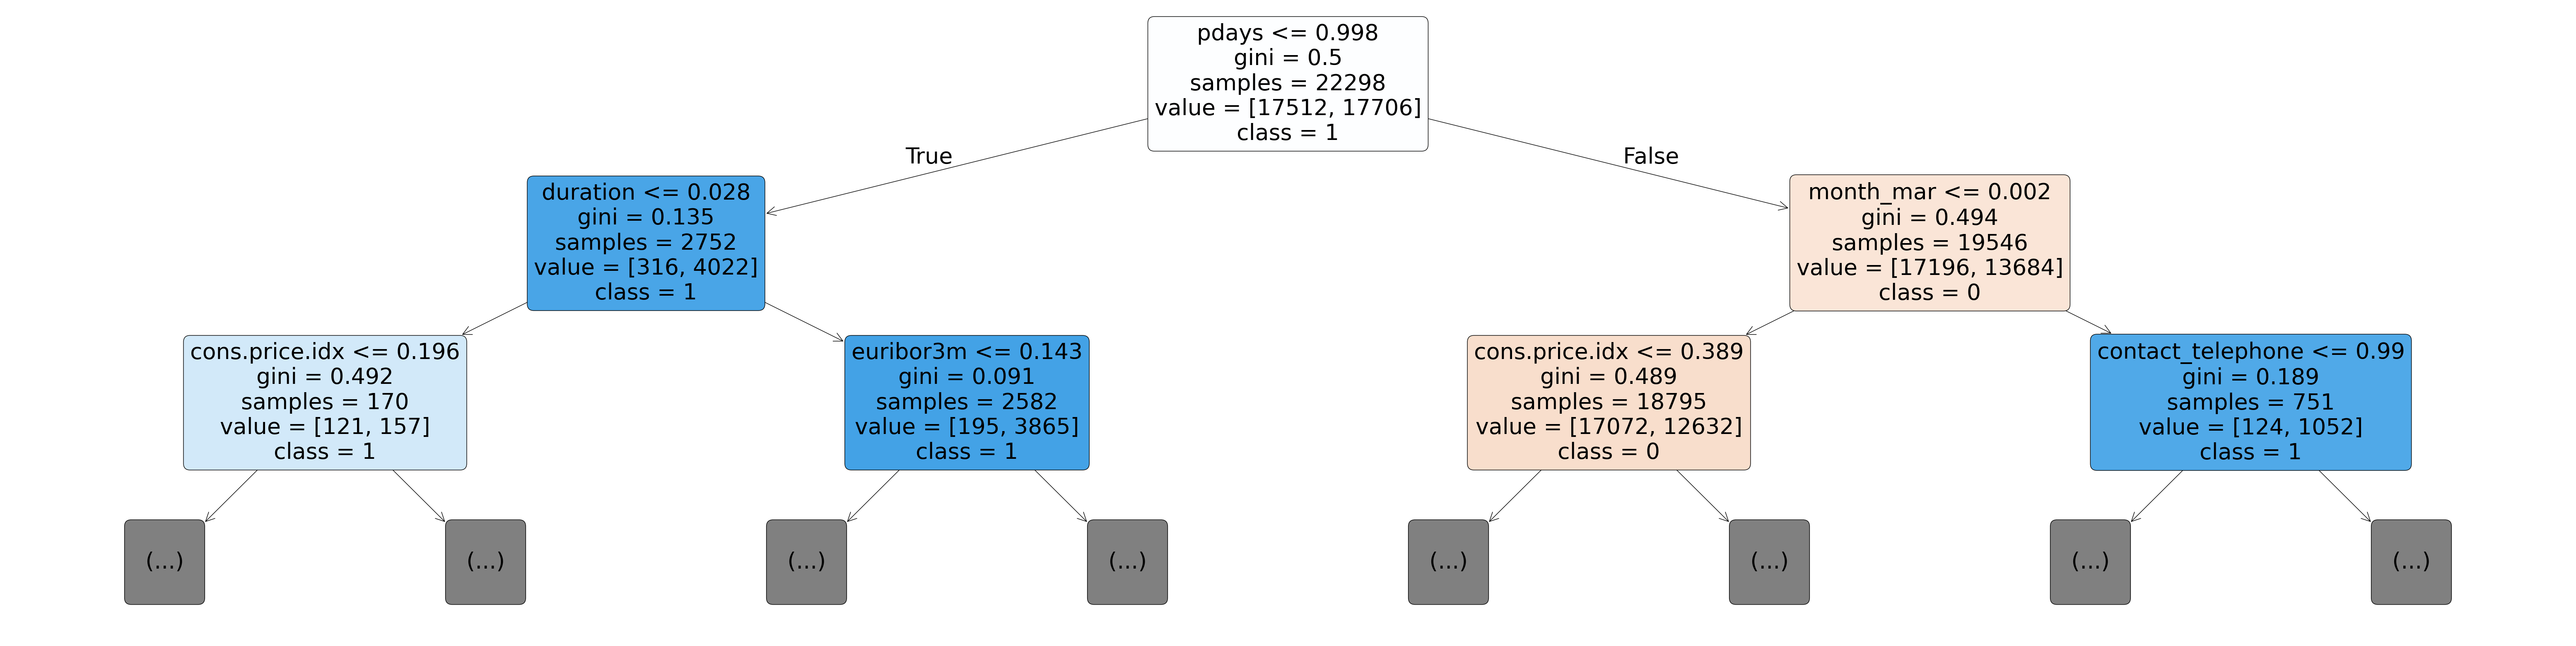

In [190]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[20], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True, class_names=[str(cls) for cls in model.classes_] );

Confusion Matrix

In [191]:
print(len(y_train_resampled), len(train_preds))


35218 35218


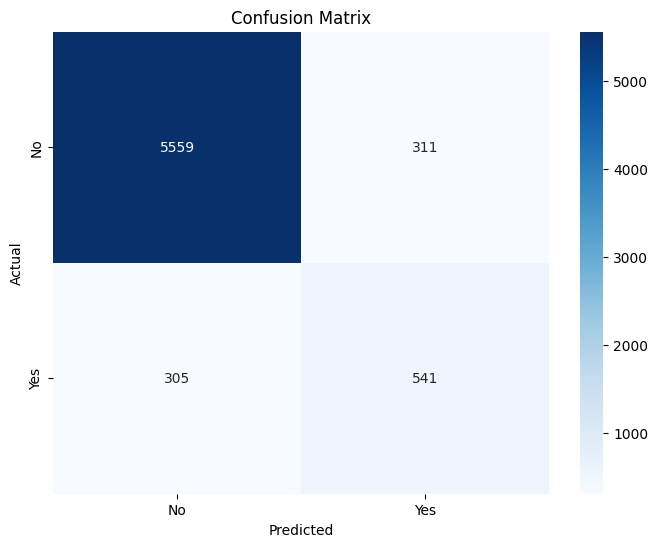

In [192]:

conf_matrix = confusion_matrix(y_val,val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',  xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [193]:
# Predict on test data
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)

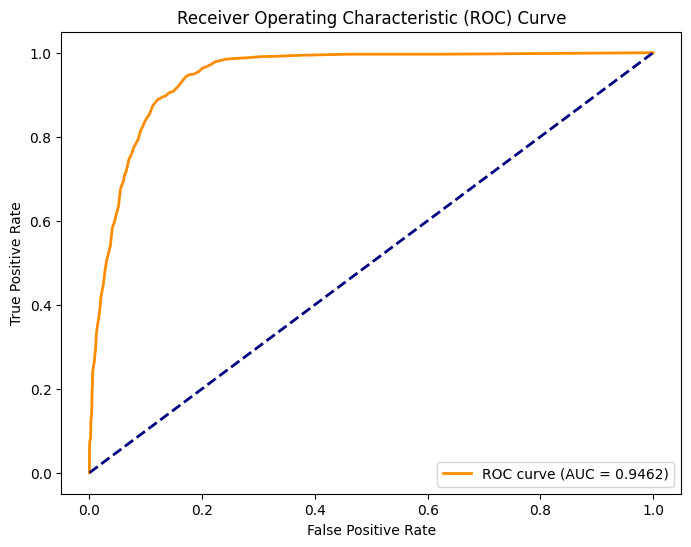

In [194]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [195]:
len(model.estimators_)

100

In [196]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [197]:
importance_df.head(10)

,feature,importance
1,duration,0.334190
8,euribor3m,0.099090
9,nr.employed,0.059844
5,emp.var.rate,0.048197
2,campaign,0.045509
0,age,0.037676
7,cons.conf.idx,0.029308
6,cons.price.idx,0.025175
3,pdays,0.022502
38,contact_telephone,0.013788


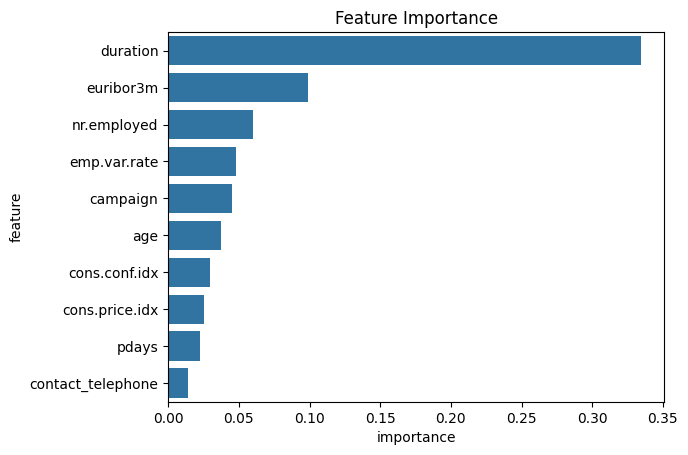

In [198]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

Hyperparameter Tuning

In [199]:
base_model = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_train, train_targets)

In [200]:
base_train_acc = base_model.score(X_train, train_targets)
base_val_acc = base_model.score(X_val, val_targets)

In [201]:
base_accs = base_train_acc, base_val_acc
base_accs

(0.9999503623548099, 0.9142346634901727)

n_estimators

In [202]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=400)#Ramdomness

In [203]:
model.fit(X_train, train_targets)

RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42)

In [204]:
model.score(X_train, train_targets), model.score(X_val, val_targets)

(1.0, 0.9118522930315665)

In [205]:
base_accs

(0.9999503623548099, 0.9142346634901727)

max_depth and max_leaf_nodes

In [206]:
def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(X_train, train_targets)
    return model.score(X_train, train_targets), model.score(X_val, val_targets)

In [207]:
test_params(max_depth=40)

(0.9999503623548099, 0.9142346634901727)

In [208]:
test_params(max_leaf_nodes=2**20)

(0.9999503623548099, 0.913787969029184)

In [209]:
base_accs # no max depth or max leaf nodes


(0.9999503623548099, 0.9142346634901727)

max_features

In [210]:
test_params(max_features=8)

(0.9999503623548099, 0.9142346634901727)

In [211]:
base_accs

(0.9999503623548099, 0.9142346634901727)

min_samples_split and min_samples_leaf

In [212]:
test_params(min_samples_split=4, min_samples_leaf=2)

(0.9763228432443165, 0.9125967837998809)

In [213]:
base_accs

(0.9999503623548099, 0.9142346634901727)

min_impurity_decrease

In [214]:
test_params(min_impurity_decrease=1e-6)

(0.9958304378040306, 0.9130434782608695)

In [215]:
base_accs

(0.9999503623548099, 0.9142346634901727)

bootstrap, max_samples

In [216]:
test_params(bootstrap=False)

(1.0, 0.9108100059559261)

In [217]:
base_accs

(0.9999503623548099, 0.9142346634901727)

In [218]:
test_params(max_samples=0.9)

(0.9997518117740495, 0.9117033948779035)

In [219]:
base_accs

(0.9999503623548099, 0.9142346634901727)

Putting it together

In [224]:
model = RandomForestClassifier(n_jobs=-1,
                               random_state=42,
                               n_estimators=400,
                               min_samples_split=4,
                                min_samples_leaf=2,
                                bootstrap=False,
                                min_impurity_decrease=10e-6


                              )
model.fit(X_train, train_targets)
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
accuracy_score( train_targets,train_pred), accuracy_score(val_targets , val_pred)

(0.9773652337933089, 0.909618820726623)

Text(0.5, 1.0, 'Confusion Matrix Random Forest')

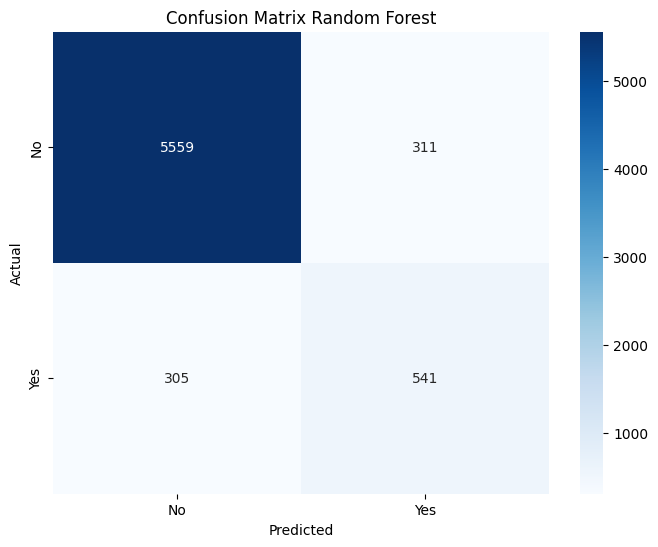

In [225]:

conf_matrix_Rf = confusion_matrix(val_targets,val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',  xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Random Forest')

In [226]:
base_accs

(0.9999503623548099, 0.9142346634901727)

# NN

In [227]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import accuracy_score


In [228]:
device = "cpu"


In [229]:
X_tensor = torch.tensor(X_train.values).float().to(device)
X_tensor

tensor([[0.2436, 0.1204, 0.0238,  ..., 1.0000, 0.0000, 0.0000],
        [0.1667, 0.0547, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.4744, 0.0350, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.1410, 0.0311, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.5256, 0.0352, 0.0476,  ..., 0.0000, 1.0000, 0.0000],
        [0.3590, 0.0331, 0.0476,  ..., 0.0000, 1.0000, 0.0000]])

In [230]:
X_tensor.shape

torch.Size([20146, 57])

In [231]:
# Convert the NumPy array to a PyTorch Tensor
Y_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)

print(Y_tensor)

tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [232]:
Y_tensor.shape

torch.Size([20146])

In [233]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Define the neural network architecture
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.output = nn.Linear(hidden2_size, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.output(x))
        return x

# Hyperparameters
input_size = 57
hidden1_size = 30
hidden2_size = 20
lr = 0.01
batch_size = 10
epochs = 4

# Track loss and accuracy during training
train_loss = []
train_accuracy = []

# Model, loss, and optimizer
model = SimpleNN(input_size, hidden1_size, hidden2_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Example synthetic data: 100 samples, 73 features each
# Labels are 0 or 1
# X_train = np.random.randn(100, input_size).astype(np.float32)  # Random features
# y_train = np.random.randint(0, 2, (100, 1)).astype(np.float32)  # Random binary labels

# Convert numpy arrays to torch tensors
train_data = TensorDataset(X_tensor, Y_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  # Clear the gradients

        output = model(data)  # Forward pass
        output = output.squeeze(1)  # Squeeze the output to match the target's shape

        loss = criterion(output, target)  # Compute the loss
        loss.backward()  # Compute the gradients
        optimizer.step()  # Update the weights

        running_loss += loss.item()
        predictions = (output > 0.5).float()  # Convert to 0 or 1
        correct_predictions += (predictions == target).sum().item()
        total_predictions += target.size(0)

    avg_loss = running_loss / len(train_loader)
    avg_accuracy = correct_predictions / total_predictions

    train_loss.append(avg_loss)
    train_accuracy.append(avg_accuracy)

    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')

# Print the final loss
print(f'Final Loss: {loss.item()}')


Epoch 1, Loss: 0.2683, Accuracy: 0.8876
Epoch 2, Loss: 0.2301, Accuracy: 0.8973
Epoch 3, Loss: 0.2205, Accuracy: 0.9009
Epoch 4, Loss: 0.2174, Accuracy: 0.9007
Final Loss: 0.3144977390766144


In [234]:
model = model.to('cpu')

In [235]:
X_train

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
31954,0.243590,0.120374,0.023810,1.000000,0.142857,0.333333,0.269680,0.192469,0.157107,0.512287,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
11487,0.166667,0.054697,0.000000,1.000000,0.000000,1.000000,0.882307,0.376569,0.980503,1.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
24969,0.474359,0.034974,0.000000,1.000000,0.000000,0.687500,0.389322,0.368201,0.797778,0.877883,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
39982,0.102564,0.134201,0.023810,0.006006,0.428571,0.354167,0.722525,0.460251,0.028792,0.105860,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
30630,0.346154,0.003050,0.071429,1.000000,0.285714,0.333333,0.269680,0.192469,0.163228,0.512287,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40397,0.128205,0.050834,0.047619,1.000000,0.714286,0.354167,0.711613,0.523013,0.061211,0.105860,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5103,0.141026,0.039244,0.023810,1.000000,0.000000,0.937500,0.698753,0.602510,0.957379,0.859735,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13062,0.141026,0.031110,0.000000,1.000000,0.000000,1.000000,0.669135,0.338912,0.981183,1.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
19975,0.525641,0.035177,0.047619,1.000000,0.000000,1.000000,0.484412,0.615063,0.982090,1.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [236]:
sample_input = X_train.loc[5103]
sample_input = torch.tensor(sample_input.values, dtype=torch.float32).unsqueeze(0) # Unsqueeze adds the batch dimension

In [237]:
with torch.no_grad():  # No need to track gradients here
    output = model(sample_input)

# Assuming binary classification and you need the probability of the positive class
probability = torch.sigmoid(output)  # Apply sigmoid if not already applied in the model

# If you want to convert probabilities to class labels based on a threshold
threshold = 0.5
predicted_labels = (probability > threshold).int()  # Get class labels as 0 or 1

print("Predicted probability:", probability.numpy())
print("Predicted y:", predicted_labels.numpy())

Predicted probability: [[0.5002657]]
Predicted y: [[1]]


In [238]:
# Convert validation data to torch tensors
X_val_tensor = torch.tensor(X_val.values).float().to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to("cpu")

# Convert test data to torch tensors
X_test_tensor = torch.tensor(X_test.values).float().to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to("cpu")

In [239]:
# Evaluation function
def evaluate(model, X, y):
    model.eval()
    with torch.no_grad():
        # Get model predictions
        output = model(X)
        output = output.squeeze(1)  # Squeeze the output to match the target's shape
        predictions = (output > 0.5).float()  # Convert probabilities to 0 or 1

        # Compute accuracy
        accuracy = accuracy_score(y, predictions)
        return predictions, accuracy

# Evaluate on the validation set
val_preds, val_accuracy = evaluate(model, X_val_tensor, y_val_tensor)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Evaluate on the test set
test_preds, test_accuracy = evaluate(model, X_test_tensor, y_test_tensor)
print(f'Test Accuracy: {test_accuracy:.4f}')

Validation Accuracy: 0.8980
Test Accuracy: 0.9014


In [240]:
# Compute loss on test set
model.eval()
with torch.no_grad():
    test_output = model(X_test_tensor).squeeze(1)
    test_loss = criterion(test_output, y_test_tensor).item()
    print(f'Test Loss: {test_loss:.4f}')

# Classification Report
print("\nClassification Report (Test):")
print(classification_report(y_test_tensor.cpu(), test_preds.cpu()))

# Confusion Matrix
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test_tensor.cpu(), test_preds.cpu()))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test_tensor.cpu(), test_preds.cpu())
print("\nROC-AUC Score (Test):")
print(roc_auc)

# Prepare results dictionary
results = {
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": test_loss,
    "val_accuracy": val_accuracy,
    "test_loss": test_loss,
    "test_accuracy": test_accuracy,
    "classification_report": classification_report(y_test_tensor.cpu(), test_preds.cpu()),
    "confusion_matrix": confusion_matrix(y_test_tensor.cpu(), test_preds.cpu()),
    "roc_auc_score": roc_auc
}

print("\nNeural Network Results Dictionary:")
print(results)

Test Loss: 0.2107

Classification Report (Test):
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94      5870
         1.0       0.66      0.45      0.54       846

    accuracy                           0.90      6716
   macro avg       0.79      0.71      0.74      6716
weighted avg       0.89      0.90      0.89      6716


Confusion Matrix (Test):
[[5670  200]
 [ 462  384]]

ROC-AUC Score (Test):
0.7099145794821607

Neural Network Results Dictionary:
{'train_loss': [0.2682969901403389, 0.23009883571094336, 0.22049399313942133, 0.21735343094250748], 'train_accuracy': [0.887620371289586, 0.8972500744564678, 0.900923260200536, 0.9006750719745855], 'val_loss': 0.2106994092464447, 'val_accuracy': 0.8980047647409172, 'test_loss': 0.2106994092464447, 'test_accuracy': 0.9014294222751638, 'classification_report': '              precision    recall  f1-score   support\n\n         0.0       0.92      0.97      0.94      5870\n         1.0       

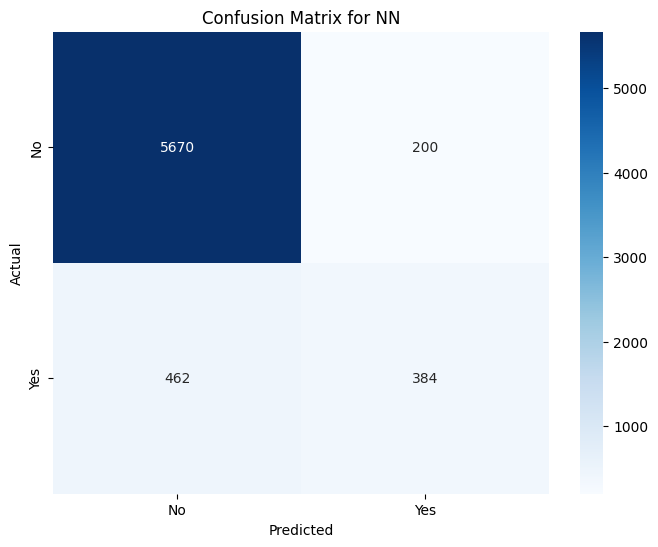

In [241]:
confusion_matrix_NN = confusion_matrix(y_test_tensor.cpu(), test_preds.cpu())
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_NN, annot=True, fmt='d', cmap='Blues',  xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for NN')
plt.show()

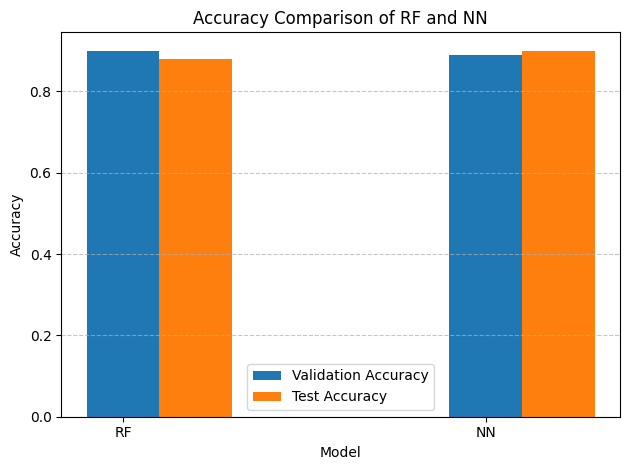

In [242]:
import matplotlib.pyplot as plt

# Accuracy values for Random Forest (RF) and Neural Network (NN)
data = {
    "Model": ["RF", "NN"],
    "Validation Accuracy": [0.90, 0.89],
    "Test Accuracy": [0.88, 0.90]
}

# Set up the plot
labels = data["Model"]
validation_acc = data["Validation Accuracy"]
test_acc = data["Test Accuracy"]

x = range(len(labels))
width = 0.2  # Bar width

plt.bar(x, validation_acc, width=width, label='Validation Accuracy')
plt.bar([i + width for i in x], test_acc, width=width, label='Test Accuracy')

# Customizing the plot
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of RF and NN")
plt.xticks(ticks=x, labels=labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


Confution Matrix

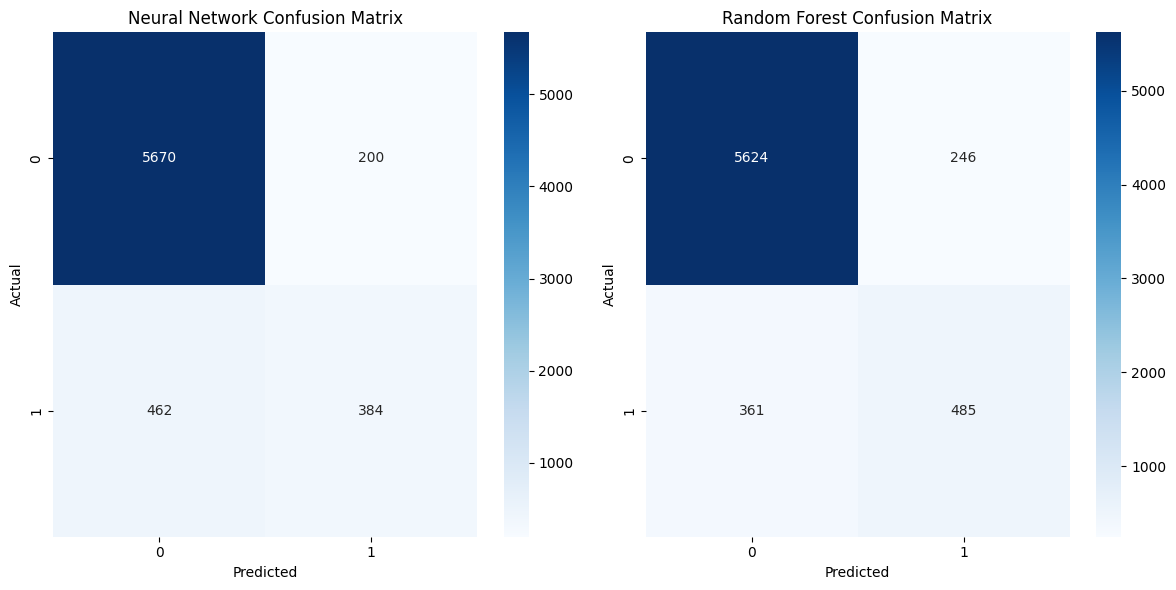

In [244]:

conf_matrix_Rf = confusion_matrix(val_targets, val_pred)
confusion_matrix_NN = confusion_matrix(y_test_tensor.cpu(), test_preds.cpu())


rf_conf_matrix = np.array(conf_matrix_Rf)
nn_conf_matrix = np.array(confusion_matrix_NN)

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(nn_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Neural Network Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Random Forest Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()